
--- KDE uniformity (interior only, m_check=20, bw_method=0.065) ---
       Point (x,y,z) │  Estimate │     Error
------------------------------------------------------------
[0.626 0.407 0.285] │    1.0008 │    0.0008
[0.223 0.226 0.313] │    0.9947 │   -0.0053
[0.569 0.676 0.443] │    0.9945 │   -0.0055
[0.219 0.225 0.74 ] │    1.0029 │    0.0029
[0.324 0.726 0.563] │    1.0013 │    0.0013
[0.769 0.389 0.377] │    1.0005 │    0.0005
[0.454 0.216 0.313] │    1.0012 │    0.0012
[0.783 0.464 0.69 ] │    1.0008 │    0.0008
[0.678 0.285 0.487] │    1.0058 │    0.0058
[0.424 0.357 0.278] │    1.0027 │    0.0027
[0.409 0.473 0.733] │    0.9991 │   -0.0009
[0.619 0.754 0.229] │    1.0002 │    0.0002
[0.654 0.545 0.356] │    0.9992 │   -0.0008
[0.53  0.561 0.679] │    0.9950 │   -0.0050
[0.765 0.274 0.437] │    0.9884 │   -0.0116
[0.566 0.402 0.449] │    1.0032 │    0.0032
[0.289 0.553 0.618] │    0.9918 │   -0.0082
[0.407 0.665 0.632] │    0.9929 │   -0.0071
[0.646 0.415 0.705] │    1.0030 │

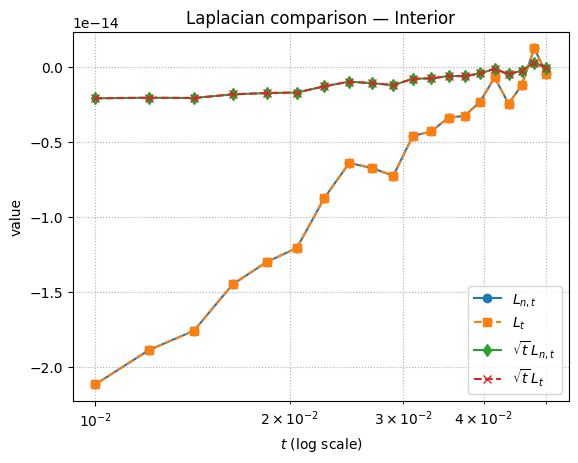

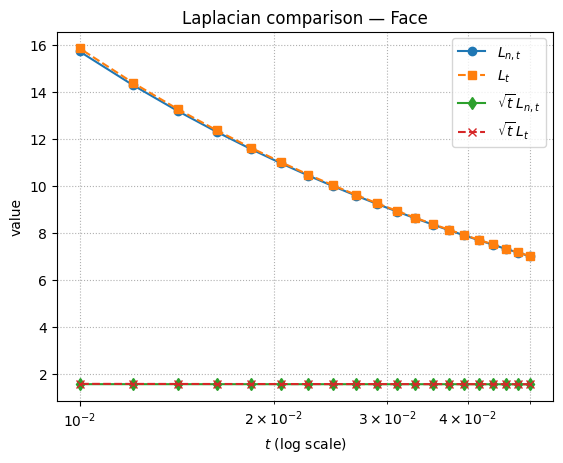

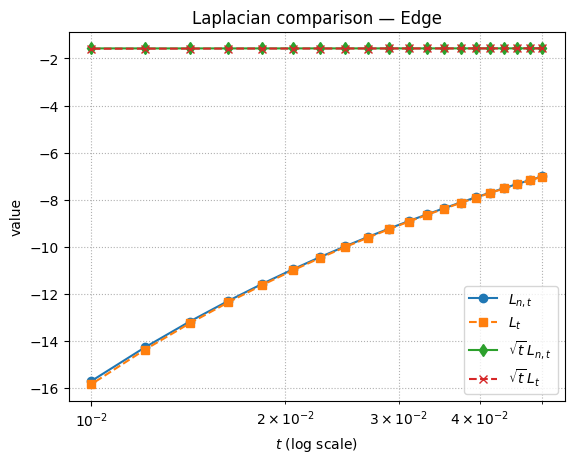

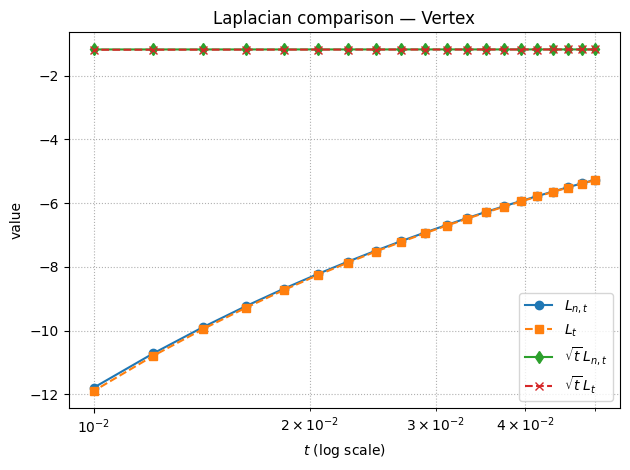

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# -------------------------------------------------------------------- #
# PARAMETERS
# -------------------------------------------------------------------- #
np.random.seed(42)
n_samples = 200_000_000
t_values  = np.linspace(0.05, 0.01, 20)
d         = 3

# -------------------------------------------------------------------- #
# 1 · Sample uniformly in [0,1]^3
# -------------------------------------------------------------------- #
def sample_uniform_hypercube(n, d=3):
    return np.random.rand(n, d)

X = sample_uniform_hypercube(n_samples, d)

# -------------------------------------------------------------------- #
# 2 · KDE Uniformity Check (20 random points) with adjustable bandwidth
# -------------------------------------------------------------------- #
def kde_uniformity(samples, m_check=20, bw_method=0.065):
    """
    samples: array of shape (n,3)
    m_check: # of random test points
    bw_method: float multiplier for bandwidth
    """
    kde   = gaussian_kde(samples.T, bw_method=bw_method)
    # oversample potential check points
    candidates = sample_uniform_hypercube(1000, samples.shape[1])
    # define a safe interior margin = 3*bw_method
    delta = 3 * bw_method
    # keep only those at least delta from any face
    mask = np.all((candidates > delta) & (candidates < 1 - delta), axis=1)
    interior = candidates[mask]
    # take the first m_check interior points
    check = interior[:m_check]
    est   = kde(check.T)
    true  = np.ones_like(est)           # uniform density=1 on [0,1]^3
    err   = est - true

    print(f"\n--- KDE uniformity (interior only, m_check={len(check)}, bw_method={bw_method}) ---")
    print(f"{'Point (x,y,z)':>20} │ {'Estimate':>9} │ {'Error':>9}")
    print("-" * 60)
    for p, e, dv in zip(check, est, err):
        print(f"{np.round(p,3)} │ {e:9.4f} │ {dv:9.4f}")
    print("-" * 60)
    print(f"Mean absolute error = {np.mean(np.abs(err)):.4f}\n")

# call it immediately to check MAE using bw_method=0.065
kde_uniformity(X, m_check=20, bw_method=0.065)



# -------------------------------------------------------------------- #
# 3 · Define test function f(x) = sum of coordinates
# -------------------------------------------------------------------- #
def f(X):
    return np.sum(X, axis=1)

# -------------------------------------------------------------------- #
# 4 · Discrete Graph Laplacian L_{n,t}
# -------------------------------------------------------------------- #
def discrete_graph_laplacian(f, x, X, t, d=3):
    diff    = f(x[None, :]) - f(X)               # shape (n,)
    weights = np.exp(-np.sum((x - X)**2, axis=1) / t)
    return np.sum(weights * diff) / (len(X) * t**(d/2 + 1))

# -------------------------------------------------------------------- #
# Interior‐point normalized Laplacian
# -------------------------------------------------------------------- #
def discrete_graph_laplacian_interior(f, x, X, t):
    diff    = f(x[None, :]) - f(X)               # shape (n,)
    weights = np.exp(-np.sum((x - X)**2, axis=1) / t)
    # normalize by the local sum of weights
    return np.sum(weights * diff) / (np.sum(weights) * t)


# -------------------------------------------------------------------- #
# 5 · Precompute mid-point grid for continuous Laplacian
# -------------------------------------------------------------------- #
m = 30
coords = np.linspace(0, 1, m, endpoint=False) + 0.5/m
grid   = np.stack(np.meshgrid(coords, coords, coords, indexing='ij'),
                  axis=-1).reshape(-1, 3)
f_grid = f(grid)

# -------------------------------------------------------------------- #
# 6 · Continuous Laplacian via Riemann sum on mid-point grid
# -------------------------------------------------------------------- #
def continuous_graph_laplacian_quadrature(f, x, t, d=3):
    fx = f(x[None, :])[0]
    sq = np.sum((grid - x)**2, axis=1)
    K  = np.exp(-sq / t)
    return np.sum(K * (fx - f_grid)) / (grid.shape[0] * t**(d/2 + 1))

# -------------------------------------------------------------------- #
# 7 · Evaluation points
# -------------------------------------------------------------------- #
eval_pts = {
    "Interior": np.array([0.5, 0.5, 0.5]),
    "Face"    : np.array([1.0, 0.5, 0.5]),
    "Edge"    : np.array([0.5, 0.0, 0.0]),
    "Vertex"  : np.array([0.0, 0.0, 0.0]),
}

# -------------------------------------------------------------------- #
# 8 · Build Laplacian table
# -------------------------------------------------------------------- #
rows = []
for t in t_values:
    row = {"t": t}
    for name, pt in eval_pts.items():
        if name == "Interior":
            Ln = continuous_graph_laplacian_quadrature(f, pt, t, d)   # == 0
        else:
            Ln = discrete_graph_laplacian(f, pt, X, t, d)


        # continuous Laplacian stays the same
        Lc = continuous_graph_laplacian_quadrature(f, pt, t, d)

        row[f"Ln_{name}"]     = Ln
        row[f"Lc_{name}"]     = Lc
        row[f"sqrtLn_{name}"] = np.sqrt(t) * Ln
        row[f"sqrtLc_{name}"] = np.sqrt(t) * Lc

    rows.append(row)

df = pd.DataFrame(rows)
pd.set_option("display.float_format", "{:.3e}".format)
print("\n--- Laplacian table ---")
print(df.to_string(index=False))


# -------------------------------------------------------------------- #
# 9 · Plot Laplacian comparisons
# -------------------------------------------------------------------- #
for name in eval_pts:
    plt.figure()
    plt.semilogx(df['t'], df[f"Ln_{name}"],      'o-',  label=r'$L_{n,t}$')
    plt.semilogx(df['t'], df[f"Lc_{name}"],      's--', label=r'$L_t$')
    plt.semilogx(df['t'], df[f"sqrtLn_{name}"], 'd-',  label=r'$\sqrt{t}\,L_{n,t}$')
    plt.semilogx(df['t'], df[f"sqrtLc_{name}"], 'x--', label=r'$\sqrt{t}\,L_t$')
    plt.xlabel('$t$ (log scale)')
    plt.ylabel('value')
    plt.title(f'Laplacian comparison — {name}')
    plt.legend()
    plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()